In [ ]:
import scanpy as sc
import pandas as pd
import os
import sys
import scipy
import anndata as ad
RHOME = os.path.join(sys.executable.split('/bin/')[0],'lib/R')
from rpy2.rinterface_lib import openrlib
openrlib.R_HOME = RHOME
import scib
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

%matplotlib inline
import faiss
print(faiss.get_num_gpus())  
import tensorflow as tf
print(tf.__version__)  # 应输出 1.15.x
import SAUCIE
from SAUCIE import SAUCIE

In [ ]:
# Import adata
adata = sc.read_h5ad("/mnt/disk2/zhongm/SCIB/数据/COVID/1/COVID_1.h5ad")

In [ ]:
adata.layers["counts"] = adata.X  # 假设raw数据中有counts数据

In [ ]:
adata

In [ ]:
adata.raw = adata

In [3]:
integration_result = {}
bench_result = {}
BATCH_KEY = 'batch'
CELLTYPE_KEY = 'celltype_level2'

In [ ]:
# # Total-count normalize (library-size correct) to 10,000 reads/cell
# sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# # log transform the data.
# sc.pp.log1p(adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, n_top_genes=2000,min_disp=0.5)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

In [ ]:
# Run PCA prior to run Harmony
sc.tl.pca(adata)

/home/zhongm/miniconda3/envs/sau3_7/lib/python3.7/site-packages/scanpy/preprocessing/_pca.py:229: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.obsm['X_pca'] = X_pca


In [25]:
# # Run PCA prior to run Harmony
# sc.tl.pca(adata)

# Harmony runs through R so:
sc.external.pp.harmony_integrate(adata, BATCH_KEY)

2025-05-09 18:53:37,846 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-09 18:55:02,251 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-09 18:55:08,927 - harmonypy - INFO - Iteration 1 of 10
2025-05-09 19:04:33,832 - harmonypy - INFO - Iteration 2 of 10
2025-05-09 19:14:08,068 - harmonypy - INFO - Iteration 3 of 10
2025-05-09 19:23:25,223 - harmonypy - INFO - Converged after 3 iterations


In [28]:
# # Run bbknn
integration_result['bbknn'] = scib.integration.bbknn(adata, BATCH_KEY)

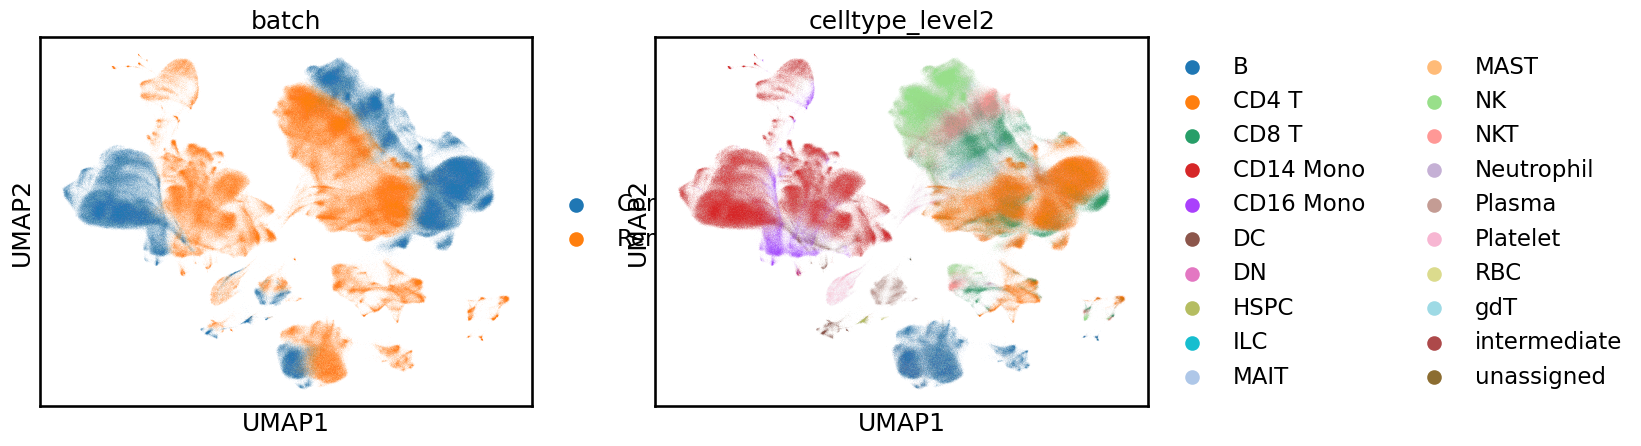

In [30]:
sc.tl.umap(integration_result['bbknn'])
sc.pl.umap(integration_result['bbknn'], color = ['batch', 'celltype_level2'])

In [34]:
# Run scanorama
integration_result['scanorama'] = scib.integration.scanorama(adata, BATCH_KEY)
integration_result['scanorama'].obs[BATCH_KEY] = adata.obs[BATCH_KEY]
integration_result['scanorama'].obs[CELLTYPE_KEY] = adata.obs[CELLTYPE_KEY].astype('category')

Found 2000 genes among all datasets


[[0.         0.23781683]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/zhongm/miniconda3/envs/faiss-3.10/lib/python3.11/site-packages/scib/utils.py:72: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  return anndata.AnnData.concatenate(*adata_list, **kwargs)


In [35]:
# Run combat
integration_result['combat'] = scib.integration.combat(adata, 'batch')

/home/zhongm/miniconda3/envs/faiss-3.10/lib/python3.11/site-packages/scanpy/preprocessing/_combat.py:350: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


In [ ]:
# Run saucie
integration_result['saucie'] = scib.integration.saucie(adata, 'batch')

In [ ]:
sc.pp.neighbors(integration_result['saucie'], use_rep="X_emb")
sc.tl.umap(integration_result['saucie'])
sc.pl.umap(integration_result['saucie'], color = ['batch', 'celltype_level2'])

In [ ]:
print(integration_result.keys())  # 确认包含整合数据的键名（如 'X_pca', 'X_integrated'）

dict_keys(['bbknn', 'scanorama', 'combat'])


In [ ]:
integration_result['scanorama'].write_h5ad('/mnt/disk2/zhongm/SCIB/COVID/1/COVID_1.integrated_data_scanorama.h5ad')
integration_result['bbknn'].write_h5ad('/mnt/disk2/zhongm/SCIB/COVID/1/COVID_1.integrated_data_bbknn.h5ad')
integration_result['combat'].write_h5ad('/mnt/disk2/zhongm/SCIB/COVID/1/COVID_1.integrated_data_combat.h5ad')
integration_result['saucie'].write_h5ad('/mnt/disk2/zhongm/SCIB/COVID/1/COVID_1.integrated_data_saucie.h5ad')

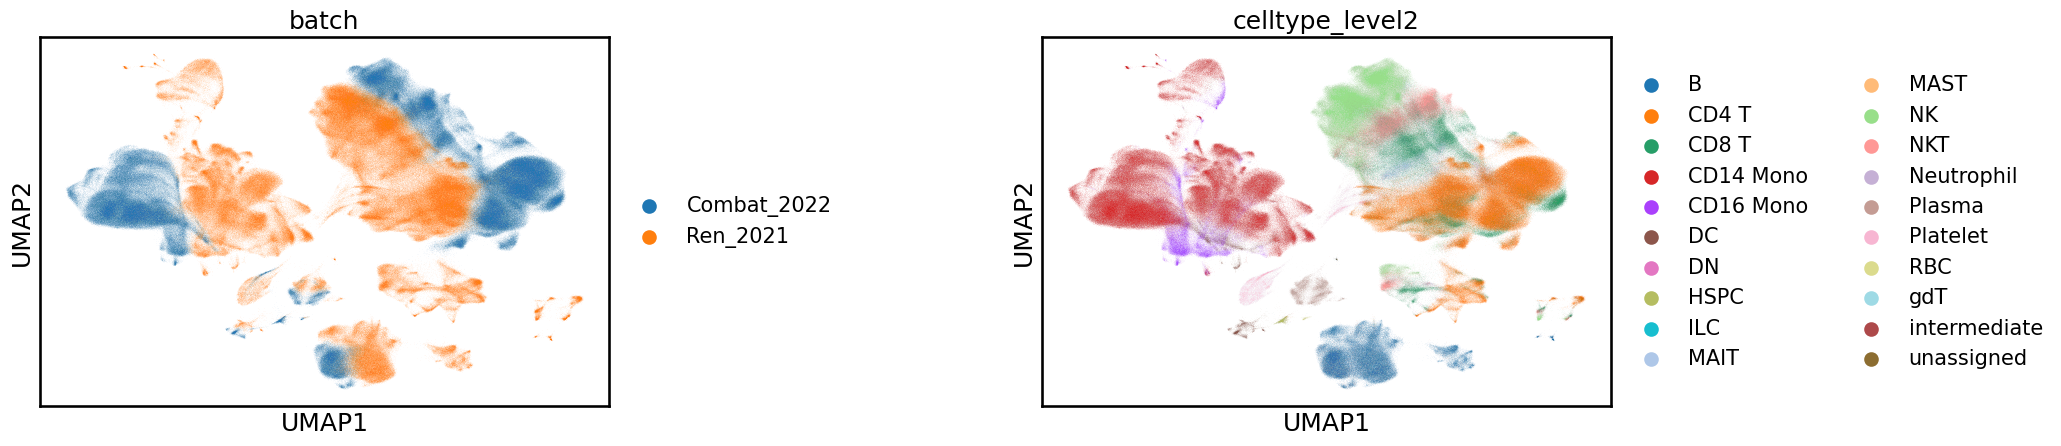

In [38]:
sc.tl.umap(integration_result['bbknn'])
sc.pl.umap(integration_result['bbknn'], color=['batch', 'celltype_level2'],
    ncols=2,
    legend_loc='right margin',     # moves legend outside plot
    legend_fontsize='small',
    legend_fontoutline=2,
    wspace=0.6      )

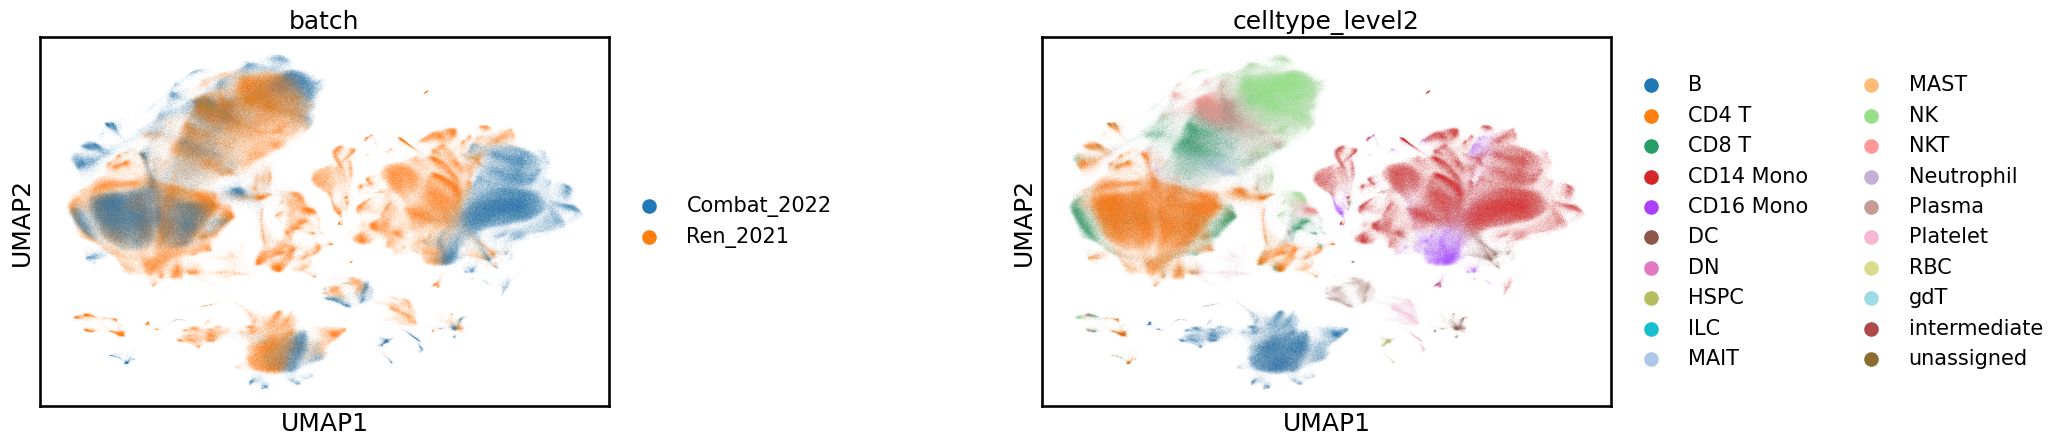

In [39]:
sc.pp.highly_variable_genes(integration_result['combat'], min_mean=0.0125, max_mean=3, n_top_genes=2000,min_disp=0.5)



# Run PCA prior to run Harmony
sc.tl.pca(integration_result['combat'])

sc.pp.neighbors(integration_result['combat'])
sc.tl.umap(integration_result['combat'])
sc.pl.umap(
    integration_result['combat'],
    color=['batch', 'celltype_level2'],
    ncols=2,
    legend_loc='right margin',     # moves legend outside plot
    legend_fontsize='small',
    legend_fontoutline=2,
    wspace=0.6                     # ← controls horizontal space between subplots
)

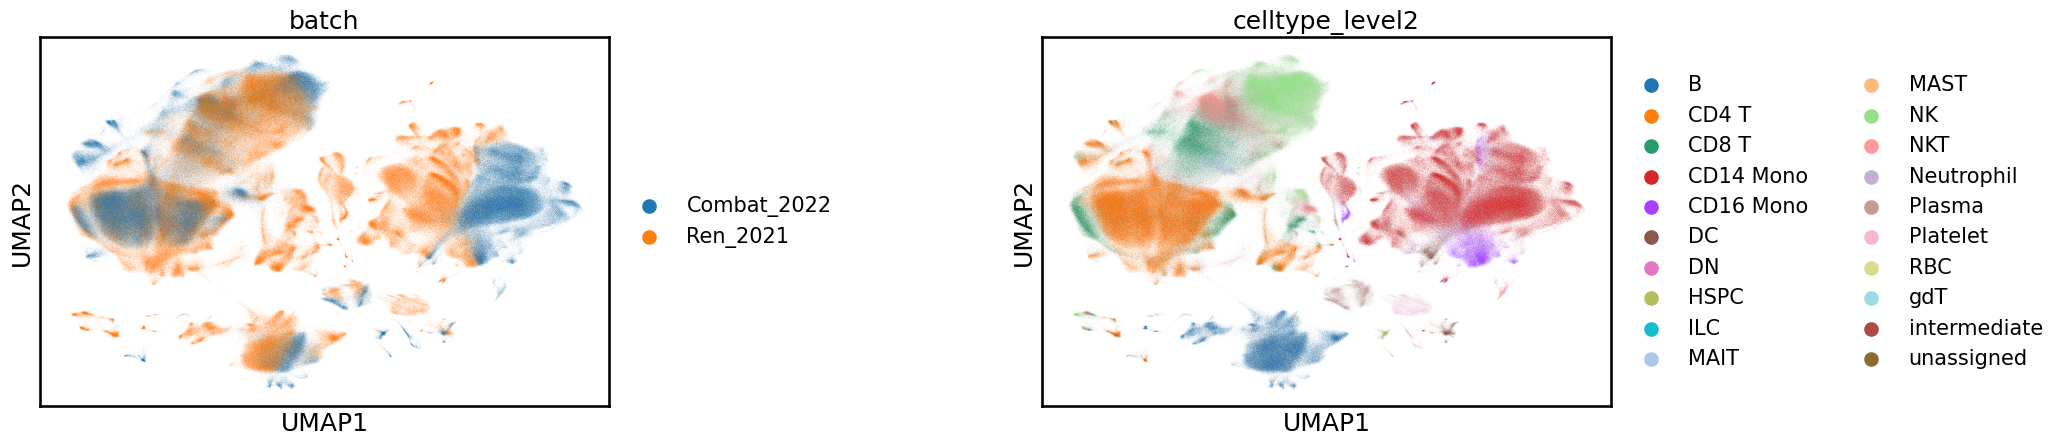

In [ ]:
sc.pp.highly_variable_genes(integration_result['saucie'], min_mean=0.0125, max_mean=3, n_top_genes=2000,min_disp=0.5)


# sc.pp.highly_variable_genes(integration_result['saucie'], n_top_genes = 2000)
# Run PCA prior to run Harmony
sc.tl.pca(integration_result['saucie'])
sc.pp.neighbors(integration_result['saucie'])
sc.tl.umap(integration_result['saucie'])
sc.pl.umap(
    integration_result['combat'],
    color=['batch', 'celltype_level2'],
    ncols=2,
    legend_loc='right margin',     # moves legend outside plot
    legend_fontsize='small',
    legend_fontoutline=2,
    wspace=0.6                     # ← controls horizontal space between subplots
)

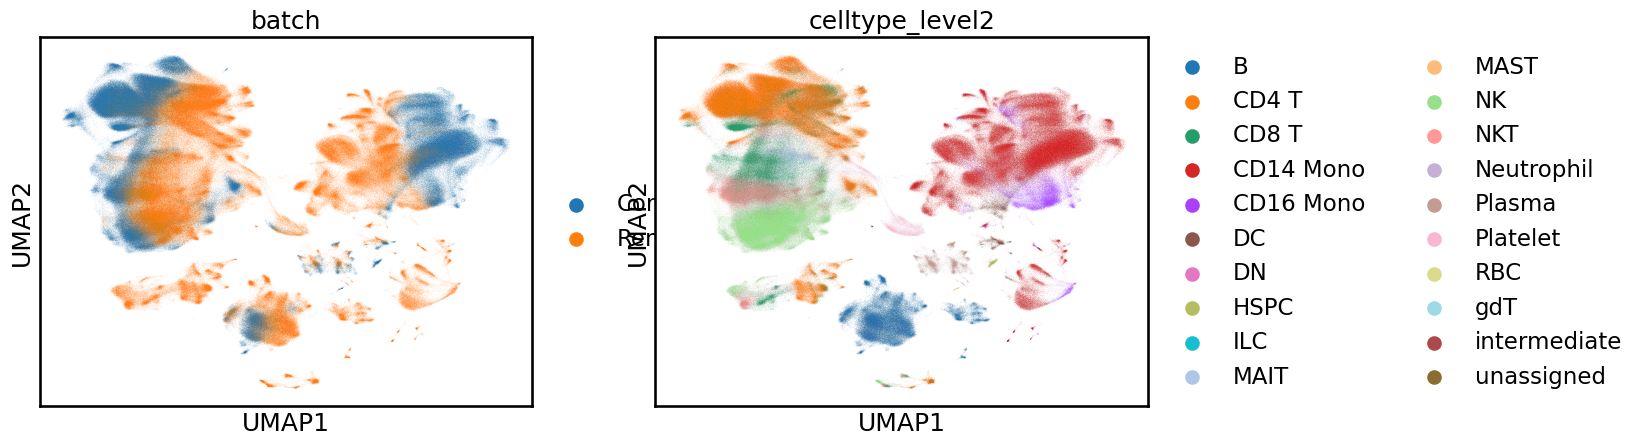

In [40]:
sc.pp.neighbors(integration_result['scanorama'], use_rep="X_emb")
sc.tl.umap(integration_result['scanorama'])
sc.pl.umap(integration_result['scanorama'], color = ['batch', 'celltype_level2'])

In [41]:
# Find neigbors for adata
sc.pp.neighbors(adata, use_rep="X_pca_harmony")

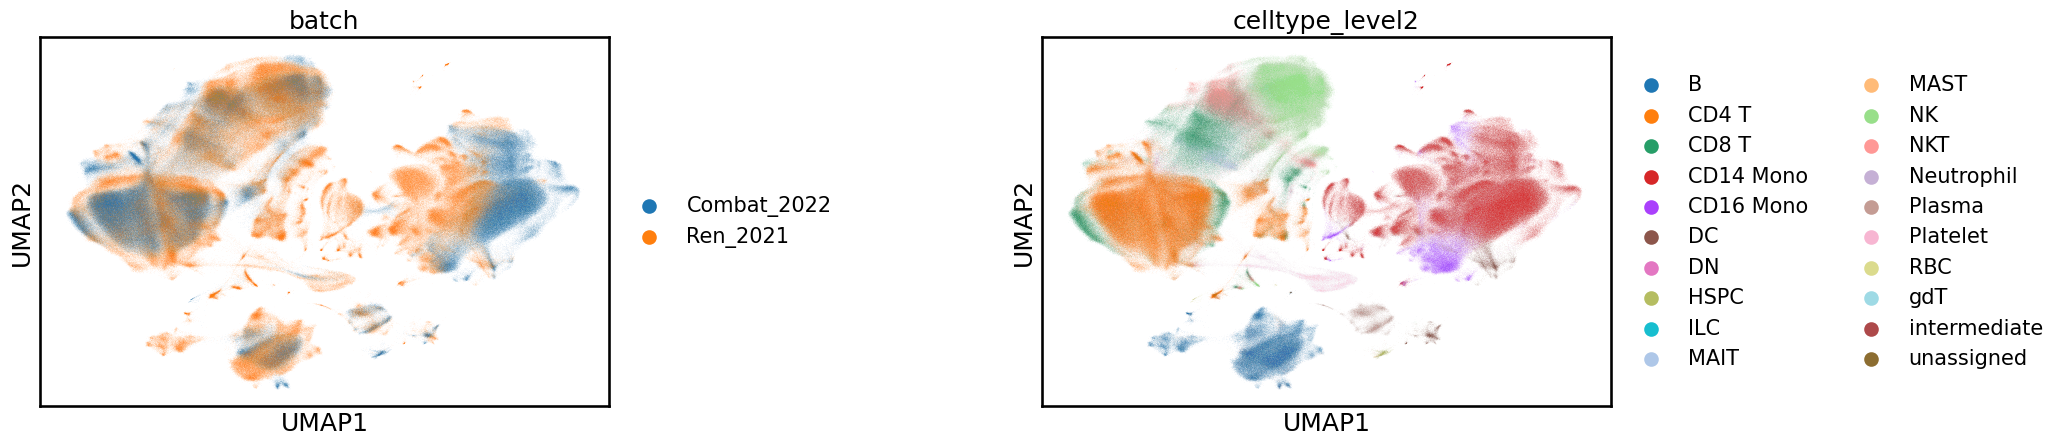

In [42]:
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=['batch', 'celltype_level2'],
    ncols=2,
    legend_loc='right margin',     # moves legend outside plot
    legend_fontsize='small',
    legend_fontoutline=2,
    wspace=0.6                     # ← controls horizontal space between subplots
)

In [43]:
sc.pp.neighbors(adata, use_rep="X_pca")

In [44]:
sc.tl.umap(adata)

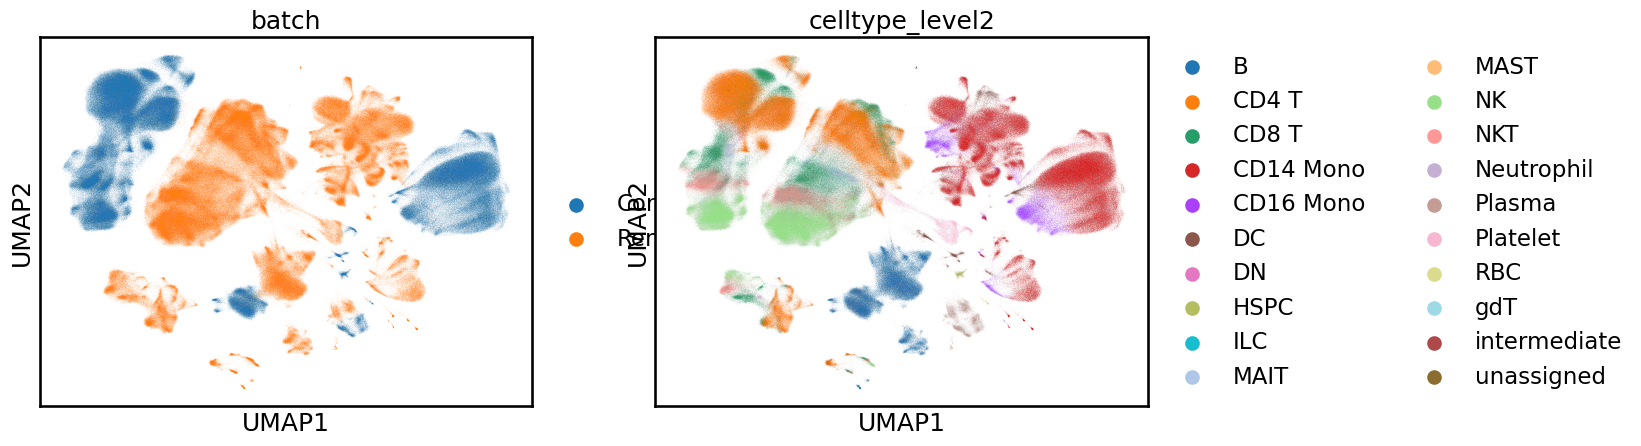

In [45]:
sc.pl.umap(adata, color = ['batch', 'celltype_level2'])

In [ ]:
integration_result

{'bbknn': AnnData object with n_obs × n_vars = 1783166 × 2000
     obs: 'batch', 'cell', 'celltype_level2'
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'celltype_level2_colors'
     obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
     varm: 'PCs'
     obsp: 'distances', 'connectivities',
 'scanorama': AnnData object with n_obs × n_vars = 1783166 × 2000
     obs: 'batch', 'cell', 'celltype_level2'
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'neighbors', 'umap', 'batch_colors', 'celltype_level2_colors'
     obsm: 'X_pca', 'X_pca_harmony', 'X_scanorama', 'X_emb', 'X_umap'
     obsp: 'distances', 'connectivities',
 'combat': AnnData object with n_obs × n_vars = 1783166 × 2000
     obs: 'batch', 'cell', 'celltype_level2'
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'celltype_level2_color

In [48]:
integration_result['scvi'] = scib.integration.scvi(adata, "batch")

/home/zhongm/miniconda3/envs/faiss-3.10/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zhongm/miniconda3/envs/faiss-3.10/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Training:   0%|          | 0/4 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


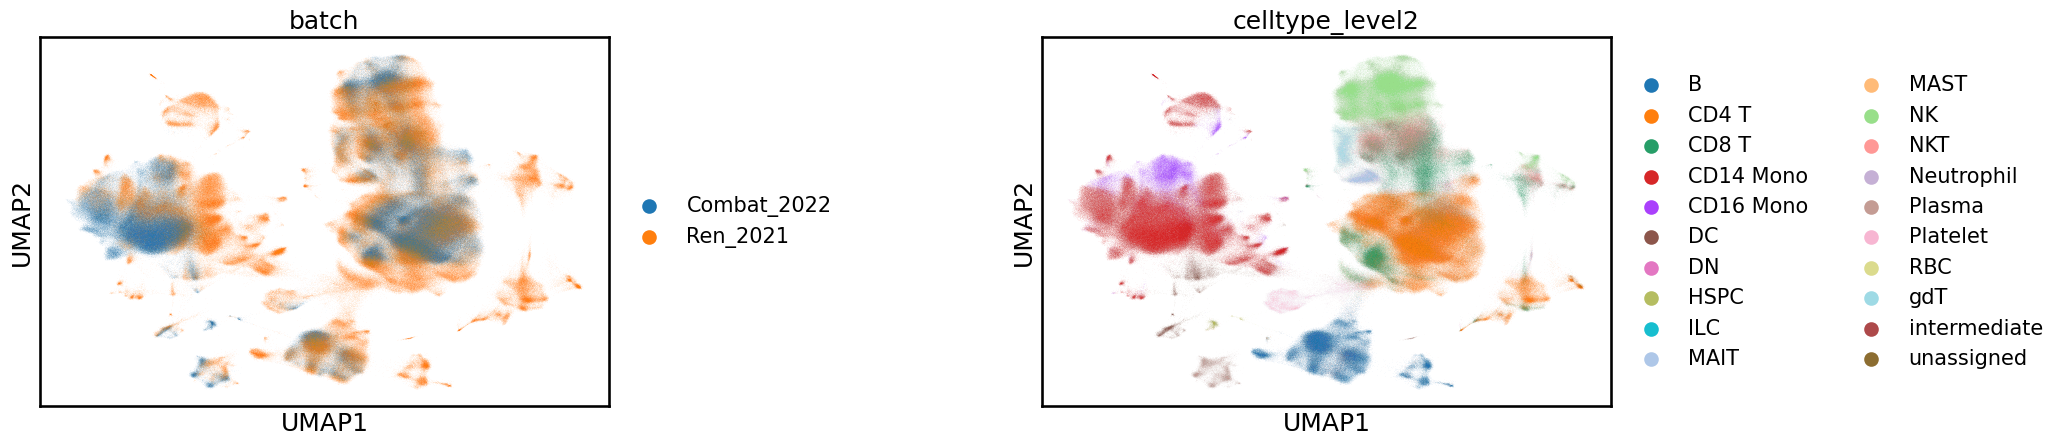

In [49]:
sc.pp.neighbors(integration_result['scvi'], use_rep="X_emb")
sc.tl.umap(integration_result['scvi'])
sc.pl.umap(
    integration_result['scvi'],
    color=['batch', 'celltype_level2'],
    ncols=2,
    legend_loc='right margin',     # moves legend outside plot
    legend_fontsize='small',
    legend_fontoutline=2,
    wspace=0.6                     # ← controls horizontal space between subplots
)

In [50]:
adata.obsm["scvi"] = integration_result['scvi'].obsm["X_emb"]

In [51]:
integration_result['scvi'].write_h5ad('/mnt/disk2/zhongm/SCIB/数据/COVID/1/COVID_1.integrated_data_scvi.h5ad')

In [22]:
integration_result['scanvi'] = scib.integration.scanvi(adata, "batch","celltype_level2")

/home/zhongm/miniconda3/envs/faiss-3.10/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zhongm/miniconda3/envs/faiss-3.10/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Training:   0%|          | 0/4 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.
/home/zhongm/miniconda3/envs/faiss-3.10/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


INFO     Training for 2 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zhongm/miniconda3/envs/faiss-3.10/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Training:   0%|          | 0/2 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


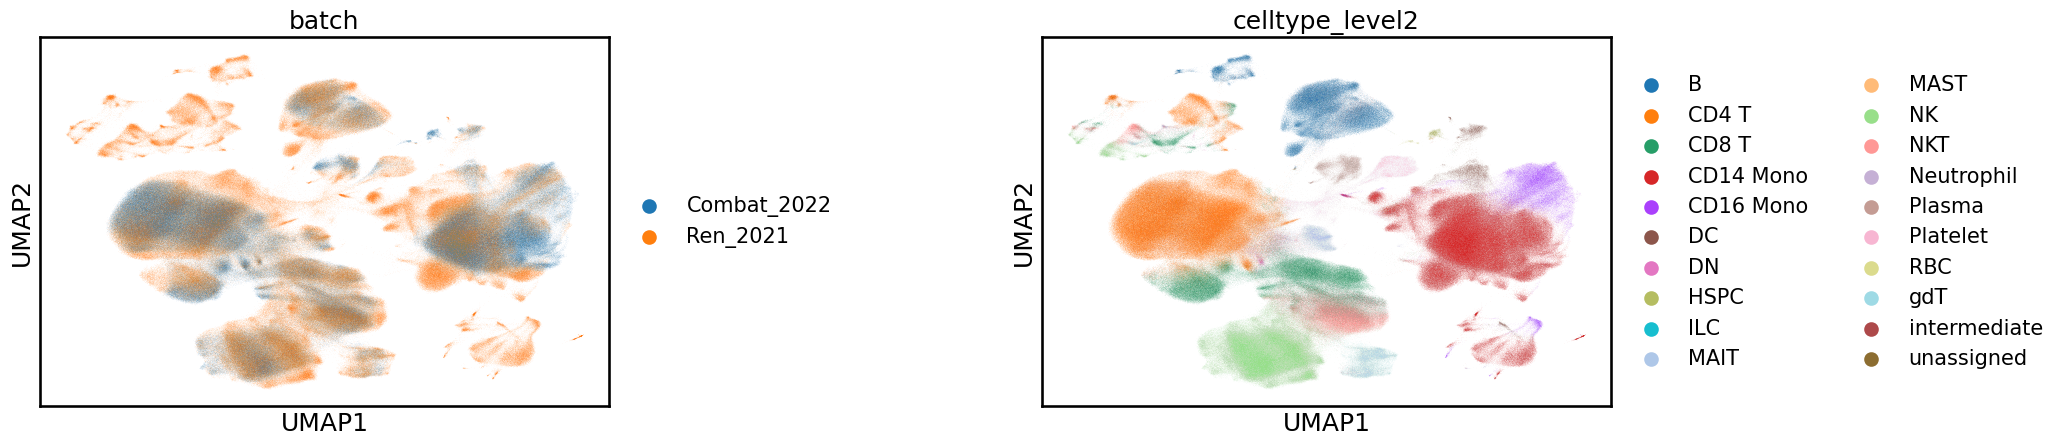

In [23]:
sc.pp.neighbors(integration_result['scanvi'], use_rep="X_emb")
sc.tl.umap(integration_result['scanvi'])
sc.pl.umap(
    integration_result['scanvi'],
    color=['batch', 'celltype_level2'],
    ncols=2,
    legend_loc='right margin',     # moves legend outside plot
    legend_fontsize='small',
    legend_fontoutline=2,
    wspace=0.6                     # ← controls horizontal space between subplots
)

In [24]:
adata.obsm["scanvi"] = integration_result['scanvi'].obsm["X_emb"]

In [ ]:
integration_result

{'bbknn': AnnData object with n_obs × n_vars = 1783166 × 2000
     obs: 'batch', 'cell', 'celltype_level2'
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'celltype_level2_colors'
     obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
     varm: 'PCs'
     obsp: 'distances', 'connectivities',
 'scanorama': AnnData object with n_obs × n_vars = 1783166 × 2000
     obs: 'batch', 'cell', 'celltype_level2'
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'neighbors', 'umap', 'batch_colors', 'celltype_level2_colors'
     obsm: 'X_pca', 'X_pca_harmony', 'bbknn', 'X_scanorama', 'X_emb', 'X_umap'
     obsp: 'distances', 'connectivities',
 'combat': AnnData object with n_obs × n_vars = 1783166 × 2000
     obs: 'batch', 'cell', 'celltype_level2'
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'celltype_lev

In [ ]:
adata.obsm["scanorama"] = integration_result['scanorama'].obsm["X_emb"]
adata.obsm["combat"] = integration_result['combat'].obsm["X_pca"]

In [ ]:
scanorama = sc.read_h5ad("/mnt/disk2/zhongm/SCIB/COVID/1/COVID_1.integrated_data_scanorama.h5ad")
scanorama


AnnData object with n_obs × n_vars = 1783166 × 2000
    obs: 'batch', 'cell', 'celltype_level2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_emb', 'X_pca', 'X_pca_harmony', 'X_scanorama', 'bbknn'

In [32]:
adata.obsm["scanorama"] = scanorama.obsm["X_emb"]

In [ ]:
bbknn = sc.read_h5ad("/mnt/disk2/zhongm/SCIB/COVID/1/COVID_1.integrated_data_bbknn.h5ad")
bbknn


AnnData object with n_obs × n_vars = 1783166 × 2000
    obs: 'batch', 'cell', 'celltype_level2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'celltype_level2_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

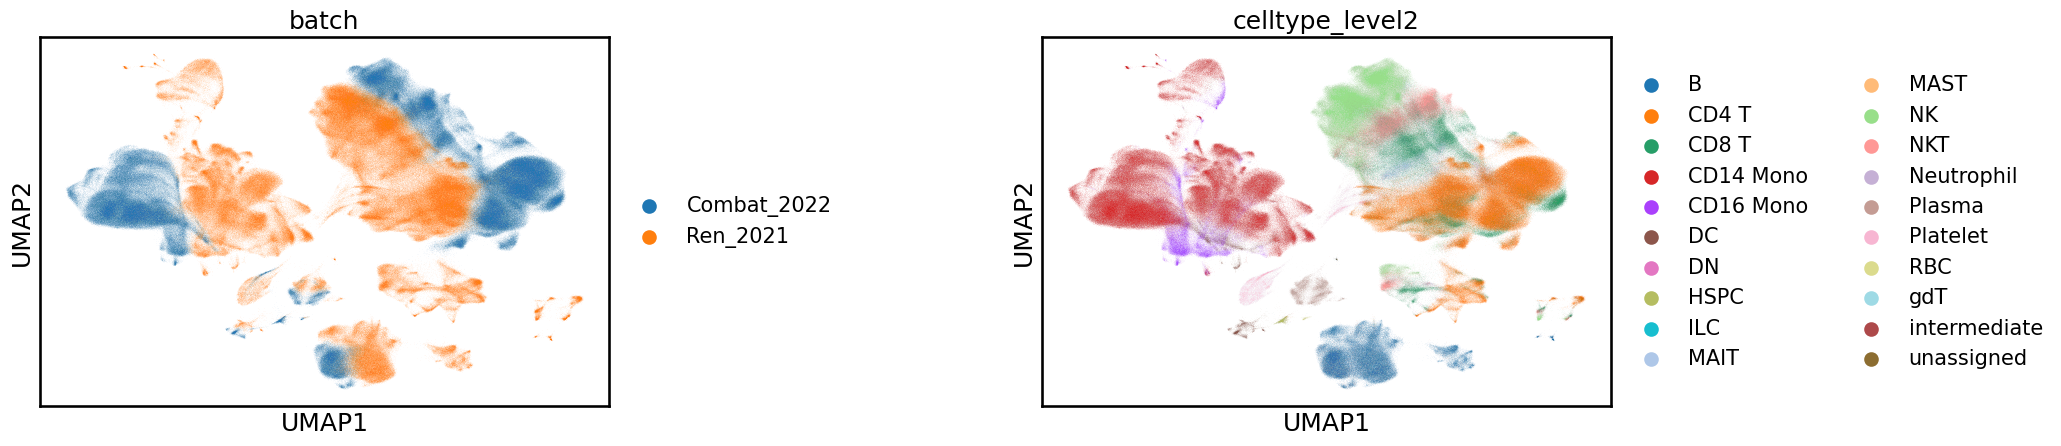

In [22]:
sc.tl.umap(bbknn)
sc.pl.umap(bbknn, color=['batch', 'celltype_level2'],
    ncols=2,
    legend_loc='right margin',     # moves legend outside plot
    legend_fontsize='small',
    legend_fontoutline=2,
    wspace=0.6      )

In [23]:
adata.obsm["bbknn"] = bbknn.obsm["X_umap"]

In [ ]:
combat = sc.read_h5ad("/mnt/disk2/zhongm/SCIB/COVID/1/COVID_1.integrated_data_combat.h5ad")
sc.pp.highly_variable_genes(combat, min_mean=0.0125, max_mean=3, n_top_genes=2000,min_disp=0.5)
# sc.pp.highly_variable_genes(integration_result['saucie'], n_top_genes = 2000)
# Run PCA prior to run Harmony
sc.tl.pca(combat)
combat

AnnData object with n_obs × n_vars = 1783166 × 2000
    obs: 'batch', 'cell', 'celltype_level2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'bbknn'
    varm: 'PCs'

In [11]:
adata.obsm["combat"] = combat.obsm["X_pca"]

In [ ]:
saucie = sc.read_h5ad("/mnt/disk2/zhongm/SCIB/COVID/1/COVID_1.integrated_data_saucie.h5ad")
sc.pp.highly_variable_genes(saucie, min_mean=0.0125, max_mean=3, n_top_genes=2000,min_disp=0.5)


# sc.pp.highly_variable_genes(integration_result['saucie'], n_top_genes = 2000)
# Run PCA prior to run Harmony
sc.tl.pca(saucie)
saucie


AnnData object with n_obs × n_vars = 760886 × 2000
    obs: 'batch', 'cell', 'celltype_level2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'

In [ ]:
adata.obsm["scanorama"] = scanorama.obsm["X_emb"]
adata.obsm["bbknn"] = bbknn.obsm["X_pca"]
adata.obsm["combat"] = combat.obsm["X_pca"]
adata.obsm["saucie"] = saucie.obsm["X_pca"]

In [ ]:
adata

AnnData object with n_obs × n_vars = 760886 × 2000
    obs: 'batch', 'cell', 'celltype_level2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'scanorama', 'bbknn', 'combat', 'saucie', 'scvi', 'scanvi'
    varm: 'PCs'

In [ ]:
saucie = sc.read_h5ad("/mnt/disk2/zhongm/SCIB/COVID/1/COVID_1.integrated_data_saucie.h5ad")
saucie

AnnData object with n_obs × n_vars = 1783166 × 2000
    obs: 'batch', 'cell', 'celltype_level2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_emb', 'X_pca'
    varm: 'PCs'

In [ ]:
sc.pp.neighbors(saucie, use_rep="X_emb")
sc.tl.umap(saucie)
sc.pl.umap(saucie ,color = ['batch', 'celltype_level2'])

In [17]:
adata.obsm["saucie"] = saucie.obsm["X_emb"]

In [13]:
adata.write_h5ad('/mnt/disk2/zhongm/SCIB/数据/COVID/1/COVID1_所有方法.h5ad')

In [8]:
import faiss

from scib_metrics.nearest_neighbors import NeighborsResults


def faiss_hnsw_nn(X: np.ndarray, k: int):
    """Gpu HNSW nearest neighbor search using faiss.

    See https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
    for index param details.
    """
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    M = 32
    index = faiss.IndexHNSWFlat(X.shape[1], M, faiss.METRIC_L2)
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsResults(indices=indices, distances=np.sqrt(distances))


def faiss_brute_force_nn(X: np.ndarray, k: int):
    """Gpu brute force nearest neighbor search using faiss."""
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    index = faiss.IndexFlatL2(X.shape[1])
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsResults(indices=indices, distances=np.sqrt(distances))

In [ ]:
import time
import pandas as pd
import psutil
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetUtilizationRates
import threading
from queue import Queue
import matplotlib.pyplot as plt
import seaborn as sns

# 初始化GPU监控（仅适用于NVIDIA GPU）
try:
    nvmlInit()
    gpu_handle = nvmlDeviceGetHandleByIndex(0)
except:
    print("GPU监控不可用")

# 定义监控函数（使用队列传递数据）
def monitor_resources(task_name, interval=1, stop_event=None, data_queue=None):
    start_time = time.time()
    while not stop_event.is_set():
        try:
            # 获取系统资源
            cpu = psutil.cpu_percent(interval=None)
            ram = psutil.virtual_memory().used / 1024**2  # 转换为MB
            gpu = nvmlDeviceGetUtilizationRates(gpu_handle).gpu if gpu_handle else 0
        except Exception as e:
            print(f"监控错误: {str(e)}")
            cpu = gpu = ram = 0
        
        # 计算相对时间
        elapsed = time.time() - start_time
        
        # 通过队列发送数据
        data_queue.put({
            'seconds': elapsed,
            'CPU': cpu,
            'GPU': gpu,
            'RAM': ram,
            'method': task_name
        })
        time.sleep(interval)

# 初始化队列和停止事件
data_queue = Queue()
stop_event = threading.Event()

# 启动监控线程
monitor_thread = threading.Thread(
    target=monitor_resources,
    args=("Benchmark", 1, stop_event, data_queue),  # 传递队列
    daemon=True
)
monitor_thread.start()

# 执行任务
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

biocons = BioConservation(isolated_labels=False)

start = time.time()
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="celltype_level2",
    embedding_obsm_keys=["X_pca", "X_pca_harmony", "scanorama","bbknn","combat","saucie","scvi","scanvi"],
    pre_integrated_embedding_obsm_key="X_pca",
    bio_conservation_metrics=biocons,
    batch_correction_metrics=BatchCorrection(),
    n_jobs=4,
)
bm.prepare(neighbor_computer=faiss_brute_force_nn)
bm.benchmark()
end = time.time()
print(f"Time: {int((end - start) / 60)} min {int((end - start) % 60)} sec")

# 停止监控
stop_event.set()
monitor_thread.join(timeout=2)

# 从队列提取数据
records = []
while not data_queue.empty():
    try:
        records.append(data_queue.get_nowait())
    except:
        break

# 转换为DataFrame
df = pd.DataFrame(records)

# 数据清洗
df = df.dropna()  # 移除可能的空值
df = df[df['seconds'] > 0]  # 过滤无效时间

# 使用 melt 函数将数据转换为长格式
df_melted = df.melt(id_vars=['seconds', 'method'], value_vars=['CPU', 'GPU', 'RAM'])

# 然后进行绘图
plt.figure(figsize=(14, 7))

sns.lineplot(
    data=df_melted[df_melted['variable'] == 'RAM'],  # 仅选择 RAM 列的数据
    x='seconds', 
    y='value', 
    hue='method',  # 使用任务名称作为色标
    style='method',  # 根据任务的不同显示不同样式的线
    palette='tab10',  # 使用不同颜色为每个任务绘制
    linewidth=1.5,
    alpha=0.8
)

# 设置坐标轴标签和标题
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("RAM Usage (MB)", fontsize=12)  # Y轴改为 RAM 使用
plt.title("Real-time RAM Usage Monitoring for Benchmark Task", fontsize=14)

# 启用网格，并调整透明度
plt.grid(True, alpha=0.3)

# 设置图例
plt.legend(title='Task Method', bbox_to_anchor=(1.05, 1), loc='upper left')

# 自动调整布局，避免图例与图表重叠
plt.tight_layout()

# 显示图表
plt.show()

# 输出运行时间
print(f"Total Benchmark Time: {int((end_time - start_time) / 60)} min {int((end_time - start_time) % 60)} sec")


Embeddings:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
adata

AnnData object with n_obs × n_vars = 1783166 × 2000
    obs: 'batch', 'cell', 'celltype_level2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'celltype_level2_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_emb', 'X_pca', 'X_pca_harmony', 'X_umap', 'bbknn', 'combat', 'saucie', 'scanorama', 'scanvi', 'scvi', 'Unintegrated'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

/home/zhongm/miniconda3/envs/faiss-3.10/lib/python3.11/site-packages/scib_metrics/benchmark/_core.py:291: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/home/zhongm/miniconda3/envs/faiss-3.10/lib/python3.11/site-packages/scib_metrics/benchmark/_core.py:291: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/home/zhongm/miniconda3/envs/faiss-3.10/lib/python3.11/site-packages/scib_metrics/benchmark/_core.py:291: FutureWarning: Setting an item of incompatible dtype is deprecated and will ra

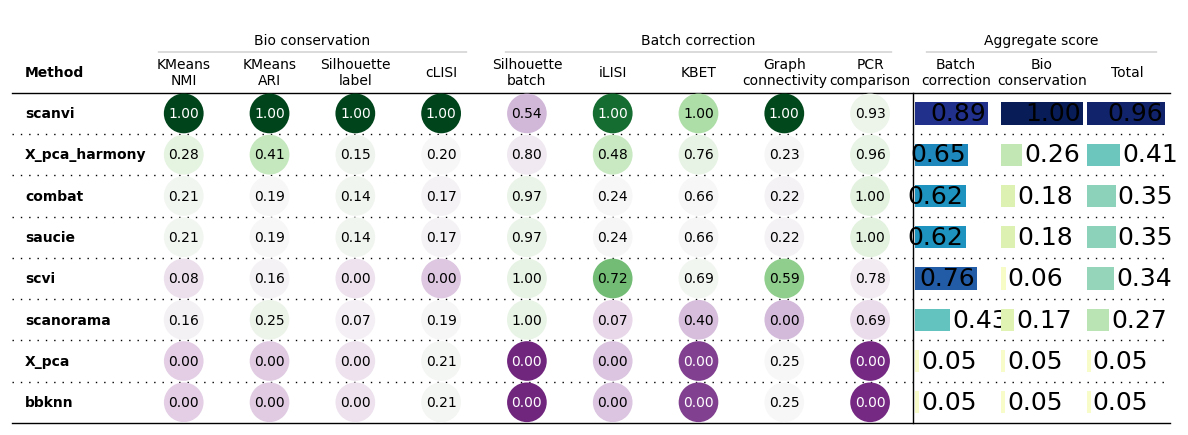

In [ ]:
bm.plot_results_table()

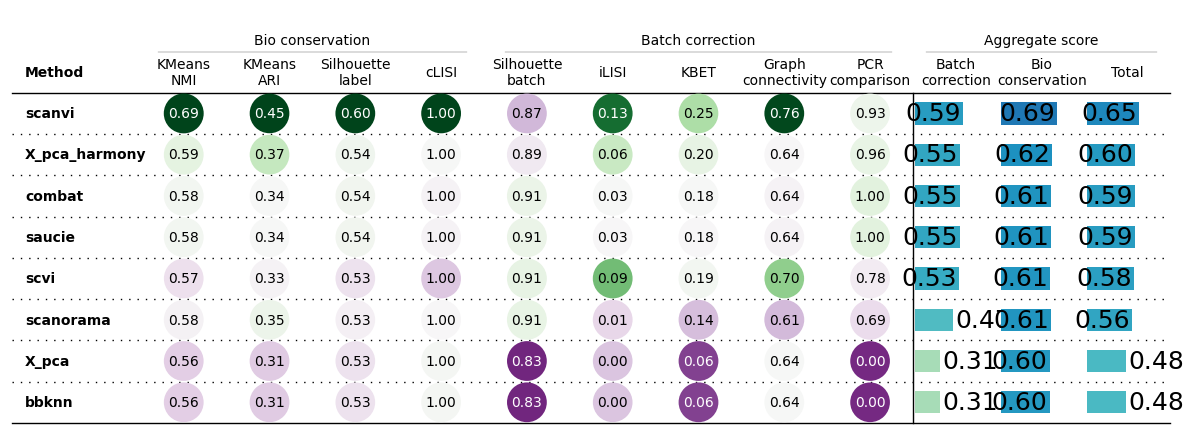

In [ ]:
bm.plot_results_table(min_max_scale=False)